In [104]:
import math
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal
from scipy.fftpack import fft
import numpy as np
import scipy.stats as st
from sklearn.decomposition import PCA
import glob
from pydub import AudioSegment
from numpy.random import uniform
import array
from pydub import AudioSegment
from pydub.utils import get_array_type
import librosa

In [23]:
def zero_pad(M):
    maxlen = max(len(r) for r in M)

    Z = np.zeros((len(M), maxlen))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row 
    return Z

def trunc(M):
    mean_len = 2*round(np.mean([len(r) for r in M]))
    Z = np.zeros((len(M), mean_len))
    for enu, row in enumerate(M):
        Z[enu, :len(row)] += row[:mean_len]
    return Z

def norm(M):
    return (M - M.min())/(M.max()-M.min())

In [3]:
filename = 'in.wav'
sound = AudioSegment.from_file(filename, format=filename[-3:])

octaves = 0.5
for octaves in np.linspace(-1,1,21):
    new_sample_rate = int(sound.frame_rate * (2.0 ** octaves))
    hipitch_sound = sound._spawn(sound.raw_data, overrides={'frame_rate': new_sample_rate})
    hipitch_sound = hipitch_sound.set_frame_rate(44100)
#export / save pitch changed sound
    hipitch_sound.export(f"octave_{octaves}.wav", format="wav")

FileNotFoundError: [Errno 2] No such file or directory: 'in.wav'

# Load the Samples

In [24]:
samples_arr = []
count = 0
file_descs = []
files = glob.glob('sflib-master/string/*.wav')
print('Row:\t Filename:')
for filename in files:
    try:
        samplerate, samples = wavfile.read(filename)
        if len(samples.shape) > 1:
            samples = samples[:,0]
        if len(samples) <= 250000:
            print(count,'\t'+filename.split('/')[2])
            count += 1
            samples_arr.append(samples)
            file_descs.append(filename.split('/')[2][:-4])
    except ValueError:
        print('reading failed for ' + filename)
print(samplerate)

Row:	 Filename:
0 	vln.m.e5.wav
1 	vc2.mf.ALT.as2.wav
2 	vc2.mf.c2.wav
3 	cb.p.gs2.wav
4 	violegam.p.ef2.wav
5 	vc2.mf.ALT1.cs4.wav
6 	vln.p.b3.wav
7 	vln.m.as4.wav
8 	cb.m.cs1.wav
9 	celharp.dmp.af5.wav
10 	celharp.soft.f3.wav
11 	violegam.short.af4.wav
12 	vc.e2.wav
13 	vla.e4.wav
14 	vc2.mf.ALT2.d4.wav
15 	violegam.short.ef2.wav
16 	vln.h.a5.wav
17 	cb.f4.wav
18 	cb.h.d3.wav
19 	vla.c6.wav
20 	celharp.soft.c4.wav
21 	celharp.dmp.af6.wav
22 	cb.p.f3.wav
23 	celharp.soft.g3.wav
24 	vln.h.c6.wav
25 	vla.gs5.wav
26 	vc.e3.wav
27 	celharp.dmp.f6.wav
28 	vln.h.f6.wav
29 	cb.h.e3.wav
30 	vc2.p.ff.ds3.wav
31 	celharp.dmp.c3.wav
32 	vc2.mf.ALT.gs3.wav
33 	violegam.short.ef3.wav
34 	vc2.mf.ALT2.cs4.wav
35 	celharp.soft.c6.wav
36 	vc2.mf.fs3.wav
37 	violegam.short.ef4.wav
38 	vc2.p.ff.c2.wav
39 	vc.h.g3.wav
40 	vln.h.cs6.wav
41 	vla.p.c3.wav
42 	vc2.mf.cs4.wav
43 	vc2.mf.ALT2.e4.wav
44 	celharp.dmp.bf5.wav
45 	vc2.mf.cs2.wav
46 	celharp.dmp.ef3.wav
47 	violegam.short.f3.wav
48 	celharp.loud.c3

/tmp/ipykernel_1178916/1381460419.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, samples = wavfile.read(filename)


In [25]:
n = len(samples_arr)
X2 = trunc(samples_arr)
downscale = 5
X2 = signal.decimate(X2, downscale, axis = 1)
samplerate = samplerate//5

# test downsampling
#wavfile.write(f'out/test_reconst_b3.wav', samplerate//5, norm(fifth))

# STFT Analysis

In [235]:
def fourier_trans(x, samplerate):
    f, t, spec = signal.stft(x, samplerate, nperseg=1000)
    return spec, f, t

_, freqs, t = fourier_trans(X2[209], samplerate)

In [173]:
np.max(np.abs(X_f[209][:,25]))

3162.6448278164708

In [327]:
def get_fundamental(x, samplerate):
    x_f = np.fft.rfft(x)
    fs = np.fft.rfftfreq(len(x), 1/samplerate)
    #plt.plot(fs[:30000], x_f[:30000])
    # oh... lol... I didn't know how to do fft with non-1 samplerate..., but usually one is fine
    for rel_thresh in np.linspace(1/3, 0.1, 10):
        peaks = signal.find_peaks(np.abs(x_f), height=np.max(x_f)*rel_thresh)[0]
        if peaks.any():
            break
    else:
        return None
    freq_index = peaks[0]
    #print(freq_index)
    freq = round(fs[freq_index], 1)
    note_name = librosa.hz_to_note(freq)
    return freq#, note_name

In [326]:
freqs[signal.find_peaks(np.abs(X_f[209][:,0]), distance = 1)[0]]

array([  52.92,   88.2 ,  132.3 ,  158.76,  176.4 ,  202.86,  229.32,
        246.96,  264.6 ,  282.24,  299.88,  326.34,  343.98,  361.62,
        379.26,  405.72,  423.36,  441.  ,  458.64,  493.92,  520.38,
        538.02,  555.66,  590.94,  635.04,  732.06,  749.7 ,  784.98,
        802.62,  846.72,  864.36,  882.  ,  908.46,  934.92,  952.56,
        996.66, 1014.3 , 1040.76, 1067.22, 1093.68, 1111.32, 1137.78,
       1155.42, 1181.88, 1199.52, 1225.98, 1252.44, 1270.08, 1296.54,
       1314.18, 1340.64, 1358.28, 1384.74, 1411.2 , 1428.84, 1455.3 ,
       1472.94, 1499.4 , 1525.86, 1543.5 , 1561.14, 1578.78, 1605.24,
       1622.88, 1675.8 , 1693.44, 1711.08, 1737.54, 1755.18, 1781.64,
       1808.1 , 1825.74, 1852.2 , 1869.84, 1887.48, 1905.12, 1922.76,
       1940.4 , 1958.04, 1984.5 , 2002.14, 2019.78, 2046.24, 2072.7 ,
       2090.34, 2116.8 , 2134.44, 2152.08, 2178.54, 2205.  , 2249.1 ,
       2302.02, 2346.12, 2363.76, 2451.96, 2478.42, 2496.06, 2522.52,
       2540.16, 2566

68.2

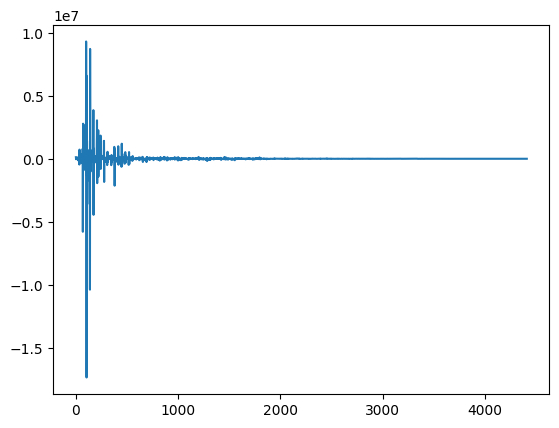

In [182]:
get_fundamental(X2[8], samplerate)

In [338]:
def partial_embedding(x, freqs, samplerate, num_partials=35):
    x_f = fourier_trans(x, samplerate)[0]
    embedding = np.zeros((num_partials, x_f.shape[1])).astype('complex128')
    def idx_of_partial(freq):
        return np.argmin(np.abs(freqs - freq))
    x_fund = get_fundamental(x, samplerate)
    
    row = 0
    partials = x_fund*np.arange(1,num_partials)
    print(partials)
    for freq in partials:
        partial_idx = idx_of_partial(freq)
        embedding[row] = x_f[partial_idx]
        row += 1
        
    return embedding, partials


#@np.vectorize
def smooth(x, sigma):
    # smooth to remove vibrato in get_freq, or just remove noise
    # using gaussian kernel with sigma=2
    kern_domain = np.linspace(-2, 2, 21+1)
    gaussian_kernel = st.norm.pdf(kern_domain, scale=sigma)
    return np.convolve(x, gaussian_kernel, mode='same')


def embedding_inverse(embedded, partials, freqs, samplerate):
    """
    given an partials-only embedding, return approximation of original x
    """
    x_f = np.zeros((len(freqs), embedded.shape[1])).astype('complex128')
    def idx_of_partial(freq):
        return np.argmin(np.abs(freqs - freq))
    
    for pamps, partial in zip(embedded, partials):
        x_f[idx_of_partial(partial)] = pamps
    
    # this sounds pretty rough, lets do a little smoothing...
    x_f = np.apply_along_axis(lambda col: smooth(col, 0.01), 0, x_f)
    x_f = np.apply_along_axis(lambda col: smooth(col, 0.1), 1, x_f)
    #return x_f
    t, x = signal.istft(x_f, samplerate)
    
    return t, x

[ 246.6  493.2  739.8  986.4 1233.  1479.6 1726.2 1972.8 2219.4 2466.
 2712.6 2959.2 3205.8 3452.4 3699.  3945.6 4192.2 4438.8 4685.4 4932.
 5178.6 5425.2 5671.8 5918.4 6165.  6411.6 6658.2 6904.8 7151.4 7398.
 7644.6 7891.2 8137.8 8384.4]


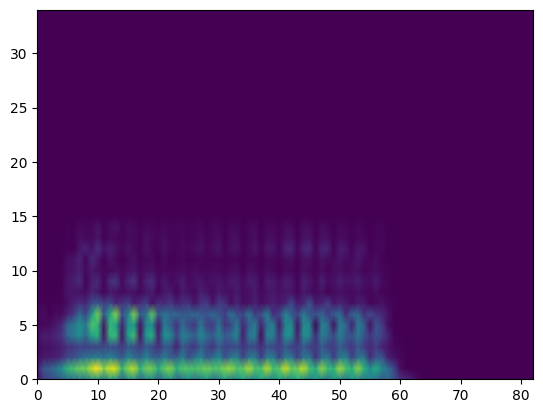

In [294]:
e, p = partial_embedding(X2[209], freqs, samplerate)
plt.pcolormesh(np.abs(e), shading='gouraud')

/tmp/ipykernel_1178916/613004306.py:1: UserWarning: shading value 'gourau`d' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(np.abs(X_f[3]), shading='gourau`d')


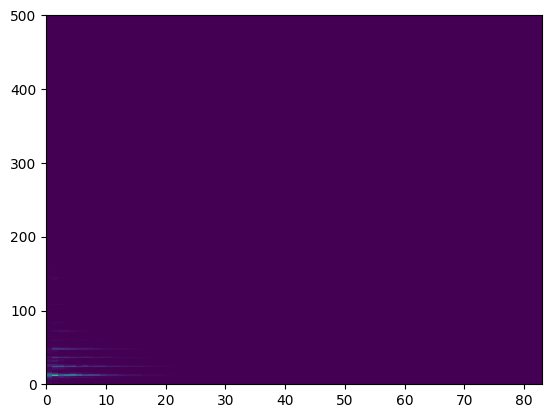

In [344]:
plt.pcolormesh(np.abs(X_f[3]), shading='gourau`d')

/tmp/ipykernel_1178916/280865947.py:1: UserWarning: shading value 'gourau`d' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolormesh(np.abs(embedding_inverse(e,p, freqs, samplerate)), shading='gourau`d')


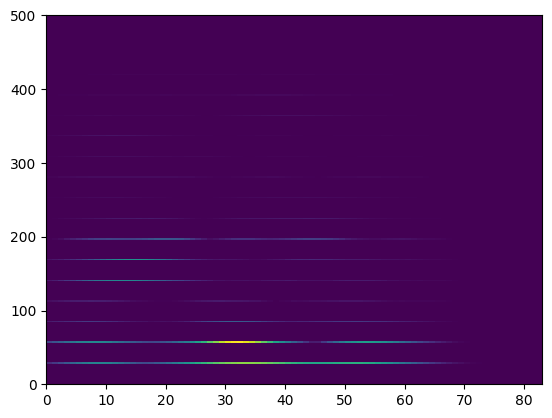

In [329]:
plt.pcolormesh(np.abs(embedding_inverse(e,p, freqs, samplerate)), shading='gourau`d')

In [339]:
t,x = embedding_inverse(e,p, freqs, samplerate)

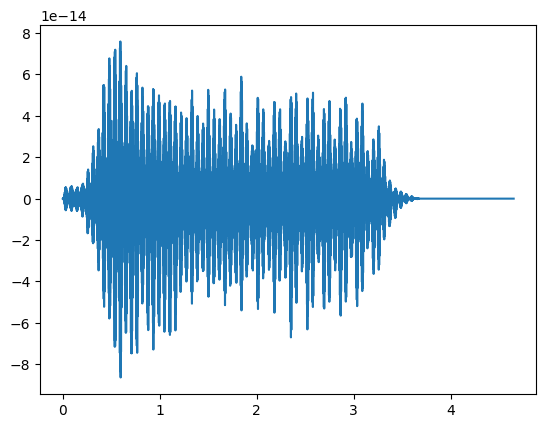

In [340]:
plt.plot(t,x)
wavfile.write('test.wav', samplerate, norm(x))

(41000,)

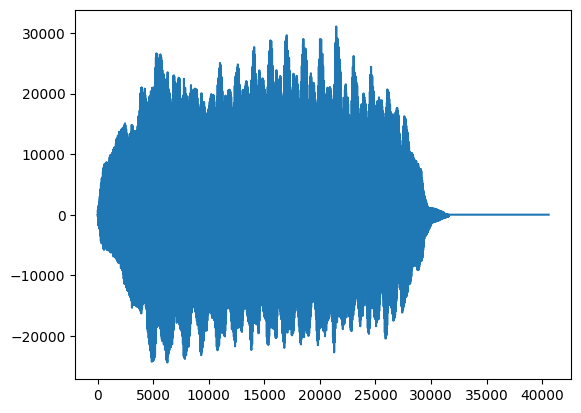

In [88]:
plt.plot(X2[209])

In [9]:
def pca(X):
    mean = X.mean(axis=0) 
    center = X - mean 
    _, stds, pcs = np.linalg.svd(center/np.sqrt(X.shape[0])) 

    return stds**2, pcs

_, dimf, dimt = X_f.shape
X_f_linearized = X_f.reshape(n, dimf*dimt)
n_comps = 100b
#pca1 = pca(X_f_linearized)

In [10]:
X_f_linearized.shape

(401, 41583)

In [168]:
pca.components_.reshape(n_comps, dimf, dimt)

(100, 513, 226)

/home/evgerritz/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


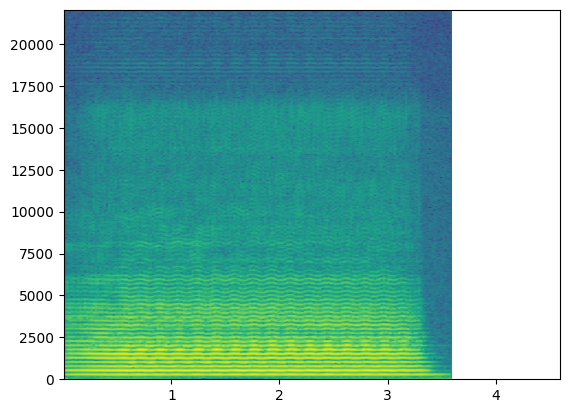

In [193]:
# original space is spectrogram of sound
reconstructed = pca.transform(fourier_trans(X2[209], samplerate)[0].reshape(1,-1)) @ pca.components_
reconstructed = reconstructed.reshape(dimf, dimt)
reconstructed = (reconstructed - reconstructed.min())/(reconstructed.max() - reconstructed.min())

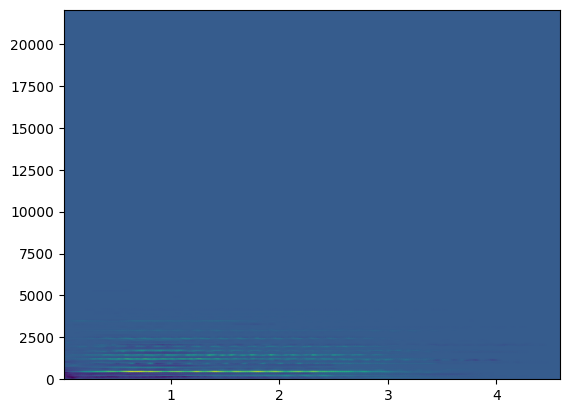

In [194]:
plt.pcolormesh(t, freqs, reconstructed, shading='gouraud')

/home/evgerritz/.local/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7622: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


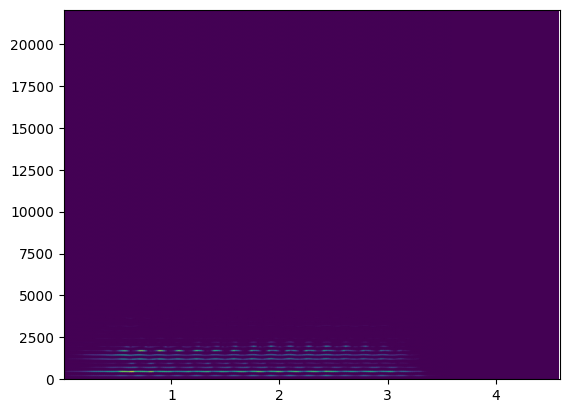

In [185]:
plt.pcolormesh(t, freqs, fourier_trans(X2[209], samplerate)[0], shading='gouraud')

In [252]:
length = len(X2[0])//226*226
t = np.linspace(0, length/samplerate, length)  #  Produces a 5 second Audio-File

y = np.sum([0.01*np.sin(freqs[freq_i] * 2 * np.pi * np.repeat(reconstructed[freq_i], length/226)*t) for freq_i in range(len(freqs)) if freq_i > 5 and freq_i < 300], axis=0)

wavfile.write('test.wav', samplerate, y)

In [242]:
length/226

898.0

# Reconstructing Recordings

In [29]:
row = 407
desc = file_descs[row]
pca = pca2; data = X2
reconstructed = pca.transform(data[row].reshape(1, -1)) @ pca.components_
reconstructed = reconstructed.astype('int16')
#reconstructed = reconstructed/max([reconstructed.max(), abs(reconstructed.min())])
wavfile.write(f'out/{desc}_reconst.wav', samplerate, reconstructed.reshape(-1,1))
wavfile.write(f'out/{desc}_original.wav', samplerate, samples_arr[row])

# Listen to what the Principal Component said

In [234]:
pca.components_.shape

(400, 109026)

In [30]:
for i in range(20):
    pc = pca.components_[i]
    pc = pc.astype('float64')
    pc = pc/max([pc.max(), abs(pc.min())])
    wavfile.write(f'pc{i}.wav', samplerate, pc.reshape(-1,1))